In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import regex

#### Loading the data

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
cols = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

df = df[cols]

df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Fill NA with 0s
df.fillna(0, inplace=True)

In [5]:
# Apply the log tranform to median_house_value
df.median_house_value = np.log1p(df.median_house_value)

In [6]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [7]:
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
targetCol = 'median_house_value'

target = df[targetCol]
data = df.drop(columns=[targetCol])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# train/validation/test split with 60%/20%/20% distribution
dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=1)
dfTrain, dfVal, yTrain, yVal = train_test_split(dfTrainFull, yTrainFull, test_size=0.25, random_state=1)

In [11]:
len(dfTrain), len(dfVal), len(dfTest)

(12384, 4128, 4128)

In [12]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categoricalCols = ['ocean_proximity']
numericalCols = list(set(dfTrain.columns).difference(categoricalCols))
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")

#### Which feature is used for splitting the data

In [14]:
modelDT = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=1))
modelDT.fit(dfTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])

In [15]:
names = list(modelDT.named_steps['columntransformer'].transformers_[0][1].get_feature_names_out(categoricalCols)) + numericalCols
names

['ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN',
 'households',
 'median_income',
 'total_bedrooms',
 'longitude',
 'total_rooms',
 'housing_median_age',
 'population',
 'latitude']

In [16]:
modelDT

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])

In [17]:
print(export_text(modelDT['decisiontreeregressor'], feature_names=names))

|--- ocean_proximity_INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity_INLAND >  0.50
|   |--- value: [11.61]



ocean_proximity_INLAND is used to split the data

#### RMSE of this model on validation (n_estimators=10, random_state=1)

In [18]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
RF = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1))
RF.fit(dfTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10, n_jobs=-1,
                                       random_state=1))])

In [19]:
yValPred = RF.predict(dfVal)
yValPred

array([12.75007188, 13.07958783, 11.36243637, ..., 12.71480652,
       12.33095461, 12.29977523])

In [20]:
from sklearn.metrics import mean_squared_error

In [25]:
rmse = mean_squared_error(yVal, yValPred, squared=False)
print(f'Mean squared error: {round(rmse,2)}')

Mean squared error: 0.25


#### After which value of n_estimators does RMSE stop improving?

In [26]:
scores = []
for n in range(10, 201, 10):
    RF = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1))
    RF.fit(dfTrain, yTrain)
    yValPred = RF.predict(dfVal)
    RMSE = mean_squared_error(yVal, yValPred)
    scores.append([n, RMSE])

In [27]:
dfScores = pd.DataFrame(scores, columns=['n_stimators', 'RMSE'])

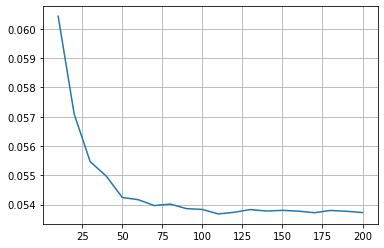

In [28]:
_ = plt.plot(dfScores.n_stimators, dfScores.RMSE)
plt.grid()
plt.show()

After n_stimators = 150

#### Let's find the best max_depth

In [29]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        RF = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1))
        RF.fit(dfTrain, yTrain)
        yValPred = RF.predict(dfVal)
        RMSE = mean_squared_error(yVal, yValPred)
        scores.append([d, n, RMSE])

In [30]:
dfScores = pd.DataFrame(scores, columns=['max_depth', 'n_stimators', 'RMSE'])

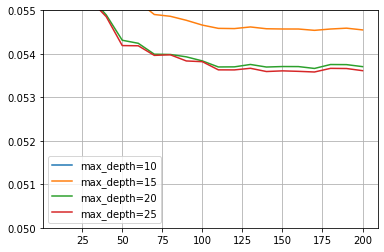

In [31]:
for d in [10, 15, 20, 25]:
    dfSubset = dfScores[dfScores.max_depth == d]
    plt.plot(dfSubset.n_stimators, dfSubset.RMSE ,label = f'max_depth={d}')
                 
plt.grid()
plt.legend()
plt.ylim(0.05, 0.055)
plt.show()

best max_depth = 20

#### Feature importance information 

In [52]:
RF = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1))
RF.fit(dfTrain, yTrain)
yValPred = RF.predict(dfVal)
RMSE = mean_squared_error(yVal, yValPred)
RMSE

0.0600661340627008

In [53]:
names = list(RF.named_steps['columntransformer'].transformers_[0][1].get_feature_names_out(categoricalCols)) + numericalCols
names

['ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN',
 'households',
 'median_income',
 'total_bedrooms',
 'longitude',
 'total_rooms',
 'housing_median_age',
 'population',
 'latitude']

In [54]:
#print(export_text(RF[1][1], feature_names=names))

In [55]:
importance = RF.steps[1][1].feature_importances_

In [56]:
featImp = list(zip(importance, names))
featImpDF = pd.DataFrame(featImp, columns=['Importance', 'Feature'])
featImpDF = featImpDF.sort_values(by='Importance', ascending=False)
featImpDF

,Importance,Feature
12,0.363161,latitude
1,0.310901,ocean_proximity_INLAND
5,0.101711,households
6,0.096212,median_income
7,0.032801,total_bedrooms
10,0.030854,housing_median_age
8,0.020796,longitude
9,0.019145,total_rooms
11,0.016574,population
4,0.004919,ocean_proximity_NEAR OCEAN


the most important feature is median_income

#### Tunning the eta parameter

In [37]:
dfTrainNew = dfTrain.copy()
dfValNew = dfVal.copy()

In [38]:
for col in categoricalCols:
    dfTrainNew[col] = dfTrainNew[col].astype("category")
    dfValNew[col] = dfValNew[col].astype("category")

In [39]:
dTrain = xgb.DMatrix(dfTrainNew, yTrain, enable_categorical=True)
dVal = xgb.DMatrix(dfValNew, yVal, enable_categorical=True)

In [40]:
watchlist = [(dTrain, 'train'), (dVal, 'val')]

In [41]:
xgbParams = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
modelxgb = xgb.train(xgbParams, dTrain, evals=watchlist, num_boost_round=101, verbose_eval=5)

[0]	train-rmse:8.12774	val-rmse:8.13350
[5]	train-rmse:1.40249	val-rmse:1.40664
[10]	train-rmse:0.34210	val-rmse:0.35636
[15]	train-rmse:0.22896	val-rmse:0.25518
[20]	train-rmse:0.21281	val-rmse:0.24632
[25]	train-rmse:0.20065	val-rmse:0.24128
[30]	train-rmse:0.19406	val-rmse:0.23874
[35]	train-rmse:0.18480	val-rmse:0.23630
[40]	train-rmse:0.17803	val-rmse:0.23568
[45]	train-rmse:0.17197	val-rmse:0.23445
[50]	train-rmse:0.16785	val-rmse:0.23413
[55]	train-rmse:0.16126	val-rmse:0.23234
[60]	train-rmse:0.15777	val-rmse:0.23151
[65]	train-rmse:0.15347	val-rmse:0.23063
[70]	train-rmse:0.14956	val-rmse:0.23033
[75]	train-rmse:0.14685	val-rmse:0.23004
[80]	train-rmse:0.14248	val-rmse:0.22926
[85]	train-rmse:0.13915	val-rmse:0.22834
[90]	train-rmse:0.13724	val-rmse:0.22844
[95]	train-rmse:0.13393	val-rmse:0.22807
[100]	train-rmse:0.13095	val-rmse:0.22824


In [42]:
scores = {}

In [47]:
%%capture output

eta = 0.3

xgbParams = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
modelxgb = xgb.train(xgbParams, dTrain, evals=watchlist, num_boost_round=101, verbose_eval=5)

In [48]:
s = output.stdout

newString = regex.findall(r'.*\[(\d+)\].*:(\d.\d+).*:(\d.\d+).*', s)
dfScores = pd.DataFrame(newString, columns=['iteration','train-squarederror', 'val-squarederror'])
dfScores =  dfScores.astype(float)
scores[f'eta={eta}'] = dfScores
scores

{'eta=0.01':     iteration  train-squarederror  val-squarederror
 0        15.0             9.88163           9.88735
 1        20.0             9.39831           9.40394
 2        25.0             8.93870           8.94423
 3        30.0             8.50164           8.50703
 4        35.0             8.08604           8.09132
 5        40.0             7.69078           7.69594
 6        45.0             7.31492           7.31995
 7        50.0             6.95750           6.96243
 8        55.0             6.61764           6.62253
 9        60.0             6.29445           6.29923
 10       65.0             5.98714           5.99193
 11       70.0             5.69492           5.69967
 12       75.0             5.41705           5.42176
 13       80.0             5.15284           5.15751
 14       85.0             4.90160           4.90620
 15       90.0             4.66271           4.66725
 16       95.0             4.43557           4.44003
 17      100.0             4.21958

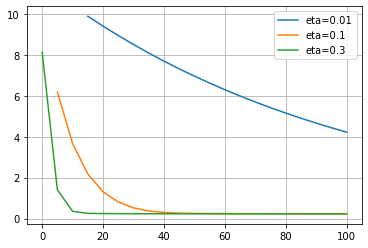

In [49]:
for key, dfScore in scores.items():
    plt.plot(dfScore.iteration, dfScore['val-squarederror'], label=key)
    
plt.legend()
plt.grid()
_ = plt.show()

Both 0.1 and 0.3 give the same RMSE Score